In [39]:
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/indian-buffet-process/data/16APR2025.h5ad")
adata = adata[adata.obs["cell_type"].eq("Microglia-PVM")]

/home/jhaberbe/Projects/indian-buffet-process/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [78]:
import torch
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("CUDA Enabled")

def setup_torch_data(adata):
    X = torch.tensor(adata[:, (adata.X > 0).mean(axis=0) > 0.05].layers["transcript"])
    size_factor = torch.tensor(np.log((adata.X.sum(axis=1) / adata.X.sum(axis=1).mean())))
    return X, size_factor

X, size_factor = setup_torch_data(adata)

X = X.to(device)
size_factor = size_factor.to(device)

/tmp/ipykernel_88405/4005202927.py:11: RuntimeWarning: divide by zero encountered in log
  size_factor = torch.tensor(np.log((adata.X.sum(axis=1) / adata.X.sum(axis=1).mean())))


In [79]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTraceMeanField_ELBO, JitTrace_ELBO
from pyro.optim import ClippedAdam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

def model(X, K_tensor, size_factor, alpha=1.0):
    K = int(K_tensor.item())
    N, D = X.shape

    alpha_param = pyro.param(
        "alpha",
        dist.Gamma(torch.full((), alpha, device=device, dtype=dtype),
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )
    beta_param = pyro.param(
        "beta",
        dist.Gamma(alpha_param,
                   torch.full((), 1.0, device=device, dtype=dtype)),
        constraint=dist.constraints.positive,
    )

    with pyro.plate("ibp_features", K):
        v = pyro.sample("v", dist.Beta(alpha_param, beta_param))  # [K]

    pi = torch.cumprod(v, dim=0)

    W = pyro.sample(
        "W",
        dist.Normal(torch.full((), 0.0, device=device, dtype=dtype),
                    torch.full((), 1.0, device=device, dtype=dtype))
        .expand([K, D]).to_event(2)
    )

    r = pyro.sample(
        "r",
        dist.Gamma(torch.full((), 2.0, device=device, dtype=dtype),
                   torch.full((), 1.0, device=device, dtype=dtype))
        .expand([D]).to_event(1)
    )
    r = r.unsqueeze(0)  # [1, D]

    with pyro.plate("observations", N):
        z = pyro.sample("Z", dist.Bernoulli(pi).to_event(1))  # [N, K]
        logits = (z @ W) + size_factor.reshape(-1, 1)  # [N, D]
        pyro.sample("X", dist.NegativeBinomial(total_count=r, logits=torch.clamp(logits, 1e-3)).to_event(1), obs=X)


def guide(X, K_tensor, size_factor):
    K = int(K_tensor.item())
    N, D = X.shape

    with pyro.plate("ibp_features", K):
        qv_alpha = pyro.param("qv_alpha", torch.ones(K, device=device, dtype=dtype),
                              constraint=dist.constraints.greater_than(1e-2))
        qv_beta = pyro.param("qv_beta", torch.ones(K, device=device, dtype=dtype),
                             constraint=dist.constraints.greater_than(1e-2))
        pyro.sample("v", dist.Beta(qv_alpha, qv_beta))

    with pyro.plate("observations", N):
        qz_logits = pyro.param("qz_logits", (torch.randn(N, K, device=device, dtype=dtype) / 100 - 2.0))
        pyro.sample("Z", dist.RelaxedBernoulliStraightThrough(
            temperature=torch.full((), 0.5, device=device, dtype=dtype),
            logits=qz_logits
        ).to_event(1))

    qW_loc = pyro.param("qW_loc", torch.randn(K, D, device=device, dtype=dtype))
    qW_scale = pyro.param("qW_scale", torch.ones(K, D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    pyro.sample("W", dist.Normal(qW_loc, qW_scale).to_event(2))

    qr_alpha = pyro.param("qr_alpha", torch.ones(D, device=device, dtype=dtype),
                          constraint=dist.constraints.positive)
    qr_beta = pyro.param("qr_beta", torch.ones(D, device=device, dtype=dtype),
                         constraint=dist.constraints.positive)
    pyro.sample("r", dist.Gamma(qr_alpha, qr_beta).to_event(1))


In [80]:
# Example training loop
pyro.clear_param_store()

X = X.to(device=device, dtype=dtype)
size_factor = size_factor.to(device=device, dtype=dtype)
K = torch.tensor(40, device=device)  # or whatever value, as a tensor


optimizer = ClippedAdam({"lr": 0.01})
elbo = JitTrace_ELBO() # Real Fn Fast
svi = SVI(model, guide, optimizer, loss=elbo)

import wandb
wandb.init(project="ibp-nb-model-lipid-droplet", name="microglia-pvm-1", config={
    "latent_dim_K": K,
    "learning_rate": 1e-2,
    "elbo": "JitTrace_ELBO",
})

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [ ]:
for step in range(100_000):
    loss = svi.step(X, K, size_factor)
    if step % 1 == 0:
        mean_logits = pyro.get_param_store()["qz_logits"].mean().item()
        percentage_logits_above_0 = (pyro.get_param_store()["qz_logits"] > 0).float().mean().item()
        
        wandb.log({
            "step": step,
            "loss": loss,
            "mean_logits": mean_logits,
            "percentage_logits_above_0": percentage_logits_above_0
        })
        
        print(f"[Step {step}] Loss: {loss:.2e}", mean_logits, percentage_logits_above_0)

/tmp/ipykernel_88405/1297031548.py:54: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  K = int(K_tensor.item())
/tmp/ipykernel_88405/1297031548.py:11: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  K = int(K_tensor.item())


[Step 0] Loss: 2.78e+07 -1.9962666034698486 0.0
[Step 1] Loss: 2.63e+07 -1.9936702251434326 0.0
[Step 2] Loss: 2.57e+07 -1.9916727542877197 0.0
[Step 3] Loss: 2.60e+07 -1.9901024103164673 0.0
[Step 4] Loss: 2.58e+07 -1.98887038230896 0.0
[Step 5] Loss: 2.49e+07 -1.987762212753296 0.0
[Step 6] Loss: 2.48e+07 -1.9868013858795166 0.0
[Step 7] Loss: 2.54e+07 -1.985986351966858 0.0
[Step 8] Loss: 2.57e+07 -1.9852339029312134 0.0
[Step 9] Loss: 2.46e+07 -1.9845829010009766 0.0
[Step 10] Loss: 2.30e+07 -1.9839125871658325 0.0
[Step 11] Loss: 2.46e+07 -1.983355164527893 0.0
[Step 12] Loss: 2.49e+07 -1.9827831983566284 0.0
[Step 13] Loss: 2.33e+07 -1.9822447299957275 0.0
[Step 14] Loss: 2.30e+07 -1.9817122220993042 0.0
[Step 15] Loss: 2.42e+07 -1.9811904430389404 0.0
[Step 16] Loss: 2.28e+07 -1.9806218147277832 0.0
[Step 17] Loss: 2.16e+07 -1.9799867868423462 0.0
[Step 18] Loss: 2.17e+07 -1.9793463945388794 0.0
[Step 19] Loss: 2.24e+07 -1.9786235094070435 0.0
[Step 20] Loss: 2.19e+07 -1.9778250

In [ ]:
pyro.get_param_store().save("/home/jhaberbe/Projects/indian-buffet-process/output/lipid-droplet/microglia-latent-features-05-08-2025.pt")
output = pyro.get_param_store()

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7a35f9364590>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7a34c0515fd0, raw_cell="pyro.get_param_store().save("/home/jhaberbe/Projec.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/indian-buffet-process/notebook/scratch.ipynb#W6sZmlsZQ%3D%3D>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x7a35f9364590>> (for post_run_cell), with arguments args (<ExecutionResult object at 7a34c0515be0, execution_count=22 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7a34c0515fd0, raw_cell="pyro.get_param_store().save("/home/jhaberbe/Projec.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/jhaberbe/Projects/indian-buffet-process/notebook/scratch.ipynb#W6sZmlsZQ%3D%3D> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

# Outcome

In [5]:
import torch
import numpy as np
output = torch.load(open("../output/fibroblast-latent-features-05-08-2025.pt", "rb"), weights_only=False)["params"]

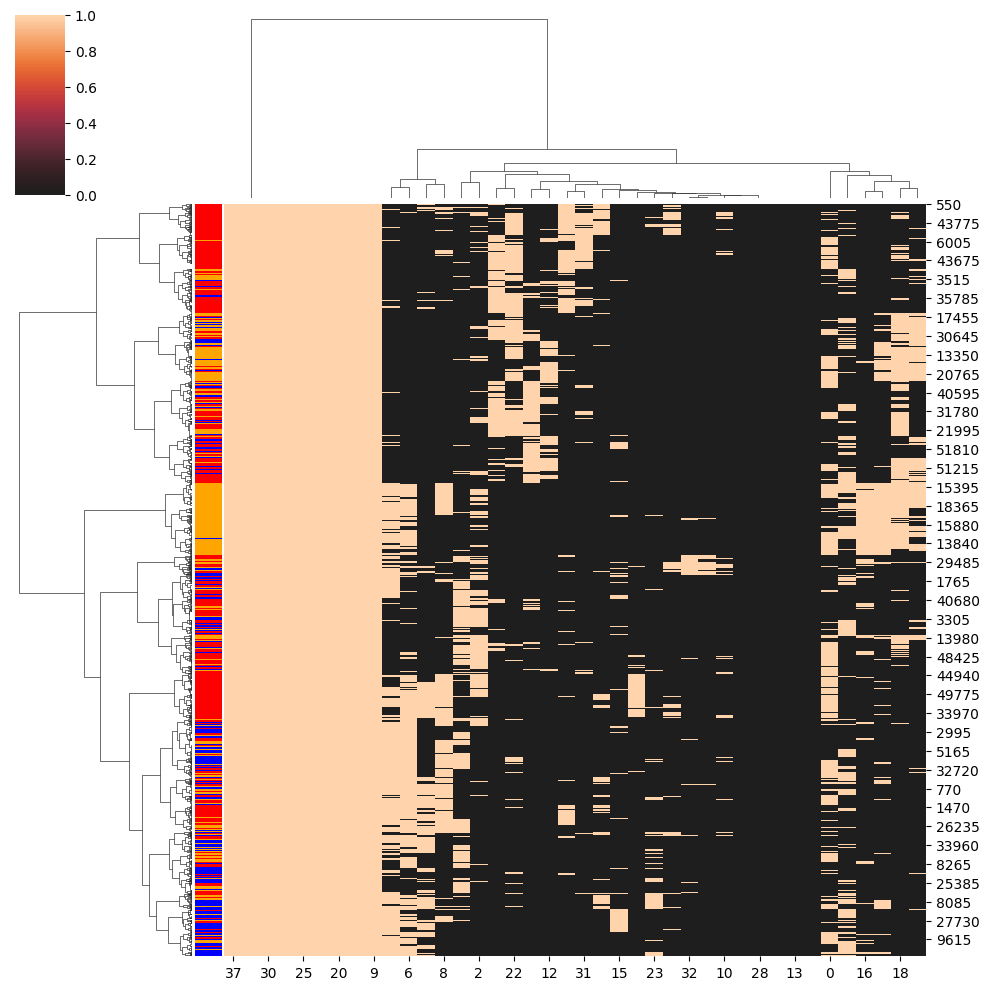

In [6]:
import pandas as pd
import seaborn as sns

sns.clustermap(
    pd.DataFrame((output["qz_logits"]).cpu().detach().numpy()).gt(0).iloc[::5],
    method="ward",
    metric="cityblock",
    center=0,
    row_colors=adata.obs["cogdx"].iloc[::5].replace({
    1: "blue",
    2: "orange",
    4: "red"
}).tolist()
)

In [7]:
latent_features = pd.DataFrame((output["qz_logits"]).cpu().detach().numpy()).gt(0)
latent_features["specimen"] = adata.obs["orig.ident"].tolist()

latent_features = latent_features.groupby(["specimen"]).sum().div(adata.obs["orig.ident"].value_counts(), axis=0)
latent_features["cog"] = [x.split("_")[1][0] for x in latent_features.index]

In [11]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
from itertools import combinations

alpha = 0.1
groups = ["C", "M", "A"]
eps = 1e-3
n_samples = 1_000  # reduce if performance is an issue

def run_pymc_beta_model(feature_vals, group_labels):
    group_idx = pd.Categorical(group_labels, categories=groups).codes
    clipped_vals = np.clip(feature_vals, eps, 1 - eps)

    with pm.Model() as model:
        a = pm.Exponential('a', 1.0, shape=len(groups))
        b = pm.Exponential('b', 1.0, shape=len(groups))
        
        obs = pm.Beta('obs', alpha=a[group_idx], beta=b[group_idx],
                      observed=clipped_vals)
        
        trace = pm.sample(n_samples, tune=1000, chains=4, progressbar=True, target_accept=0.9)
        
    return trace

def credible_difference(trace, param, group1, group2, threshold=0.95):
    # Extract posterior samples for group-specific parameter (e.g. alpha[0], alpha[1])
    samples1 = trace.posterior[param].sel(a_dim_0=groups.index(group1)).values.flatten()
    samples2 = trace.posterior[param].sel(a_dim_0=groups.index(group2)).values.flatten()
    
    diff = samples1 - samples2
    prob_diff = np.mean(diff > 0)  # P(group1 > group2)

    # Two-sided
    prob = max(prob_diff, 1 - prob_diff)
    return prob > threshold, prob

# ---- Main Loop ----
for feature in latent_features.columns:
    if feature == "cog":
        continue
    if latent_features[feature].mean() == 1 or latent_features[feature].mean() == 0:
        continue

    df = latent_features[[feature, "cog"]].dropna()
    if df["cog"].nunique() < 2:
        continue

    print(f"\n🔎 Running Bayesian beta model for '{feature}'")
    trace = run_pymc_beta_model(df[feature].values, df["cog"])

    # Pairwise group comparisons based on posterior of means
    for g1, g2 in combinations(groups, 2):
        # Compute posterior means from alpha and beta
        a1 = trace.posterior['a'].sel(a_dim_0=groups.index(g1)).values.flatten()
        b1 = trace.posterior['b'].sel(b_dim_0=groups.index(g1)).values.flatten()
        a2 = trace.posterior['a'].sel(a_dim_0=groups.index(g2)).values.flatten()
        b2 = trace.posterior['b'].sel(b_dim_0=groups.index(g2)).values.flatten()

        mean1 = a1 / (a1 + b1)
        mean2 = a2 / (a2 + b2)

        prob_diff = np.mean(mean1 > mean2)
        prob = max(prob_diff, 1 - prob_diff)

        direction = ">" if prob_diff > 0.5 else "<"
        print(f"  ➤ {g1} {direction} {g2} with {prob:.2%} certainty based on mean")



Initializing NUTS using jitter+adapt_diag...



🔎 Running Bayesian beta model for '0'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 65.33% certainty based on mean
  ➤ C > A with 71.83% certainty based on mean
  ➤ M > A with 82.53% certainty based on mean

🔎 Running Bayesian beta model for '1'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 75.65% certainty based on mean
  ➤ C < A with 54.52% certainty based on mean
  ➤ M > A with 74.38% certainty based on mean

🔎 Running Bayesian beta model for '2'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 60.00% certainty based on mean
  ➤ C < A with 65.98% certainty based on mean
  ➤ M < A with 55.28% certainty based on mean

🔎 Running Bayesian beta model for '3'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 76.90% certainty based on mean
  ➤ C > A with 84.95% certainty based on mean
  ➤ M > A with 58.73% certainty based on mean

🔎 Running Bayesian beta model for '4'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 79.77% certainty based on mean
  ➤ C > A with 61.48% certainty based on mean
  ➤ M < A with 73.25% certainty based on mean

🔎 Running Bayesian beta model for '5'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 71.15% certainty based on mean
  ➤ C > A with 58.65% certainty based on mean
  ➤ M < A with 65.70% certainty based on mean

🔎 Running Bayesian beta model for '6'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 63.58% certainty based on mean
  ➤ C > A with 79.10% certainty based on mean
  ➤ M > A with 67.17% certainty based on mean

🔎 Running Bayesian beta model for '8'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 69.05% certainty based on mean
  ➤ C > A with 66.45% certainty based on mean
  ➤ M < A with 52.55% certainty based on mean

🔎 Running Bayesian beta model for '10'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 58.27% certainty based on mean
  ➤ C > A with 73.05% certainty based on mean
  ➤ M > A with 65.90% certainty based on mean

🔎 Running Bayesian beta model for '11'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 57.75% certainty based on mean
  ➤ C < A with 84.70% certainty based on mean
  ➤ M < A with 79.80% certainty based on mean

🔎 Running Bayesian beta model for '12'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 66.33% certainty based on mean
  ➤ C < A with 70.23% certainty based on mean
  ➤ M < A with 85.70% certainty based on mean

🔎 Running Bayesian beta model for '14'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 55.73% certainty based on mean
  ➤ C < A with 72.72% certainty based on mean
  ➤ M < A with 67.53% certainty based on mean

🔎 Running Bayesian beta model for '15'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 80.75% certainty based on mean
  ➤ C > A with 64.80% certainty based on mean
  ➤ M < A with 71.78% certainty based on mean

🔎 Running Bayesian beta model for '16'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 73.62% certainty based on mean
  ➤ C > A with 57.70% certainty based on mean
  ➤ M > A with 82.47% certainty based on mean

🔎 Running Bayesian beta model for '17'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 54.75% certainty based on mean
  ➤ C < A with 57.38% certainty based on mean
  ➤ M < A with 54.25% certainty based on mean

🔎 Running Bayesian beta model for '18'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 63.27% certainty based on mean
  ➤ C > A with 59.15% certainty based on mean
  ➤ M > A with 70.43% certainty based on mean

🔎 Running Bayesian beta model for '22'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 73.25% certainty based on mean
  ➤ C > A with 58.05% certainty based on mean
  ➤ M < A with 69.10% certainty based on mean

🔎 Running Bayesian beta model for '23'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 50.70% certainty based on mean
  ➤ C > A with 73.85% certainty based on mean
  ➤ M > A with 75.70% certainty based on mean

🔎 Running Bayesian beta model for '26'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 53.62% certainty based on mean
  ➤ C < A with 82.65% certainty based on mean
  ➤ M < A with 86.02% certainty based on mean

🔎 Running Bayesian beta model for '29'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 51.78% certainty based on mean
  ➤ C > A with 69.40% certainty based on mean
  ➤ M > A with 68.35% certainty based on mean

🔎 Running Bayesian beta model for '31'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C < M with 52.88% certainty based on mean
  ➤ C < A with 67.00% certainty based on mean
  ➤ M < A with 65.03% certainty based on mean

🔎 Running Bayesian beta model for '32'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 52.48% certainty based on mean
  ➤ C > A with 61.98% certainty based on mean
  ➤ M > A with 58.93% certainty based on mean

🔎 Running Bayesian beta model for '33'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 54.73% certainty based on mean
  ➤ C > A with 64.25% certainty based on mean
  ➤ M > A with 59.40% certainty based on mean

🔎 Running Bayesian beta model for '35'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...


  ➤ C > M with 62.45% certainty based on mean
  ➤ C > A with 82.58% certainty based on mean
  ➤ M > A with 73.05% certainty based on mean

🔎 Running Bayesian beta model for '36'


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


  ➤ C < M with 64.40% certainty based on mean
  ➤ C > A with 82.33% certainty based on mean
  ➤ M > A with 90.83% certainty based on mean

🔎 Running Bayesian beta model for '39'


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


  ➤ C > M with 72.92% certainty based on mean
  ➤ C > A with 71.25% certainty based on mean
  ➤ M < A with 54.90% certainty based on mean


<Axes: xlabel='variable', ylabel='value'>

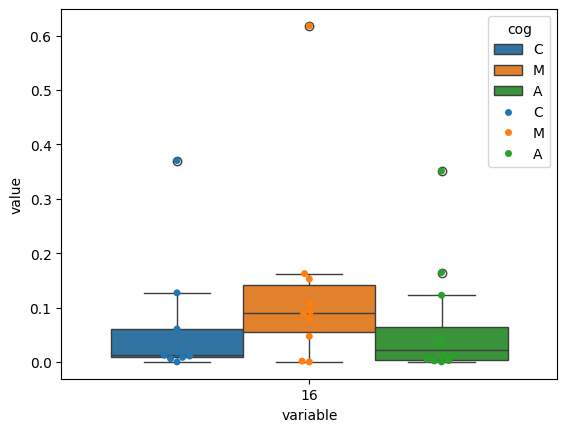

In [ ]:
import seaborn as sns

module = 16
sns.boxplot(
    latent_features.reset_index().melt(id_vars=["index", "cog"]).query("variable == @module"),
    x="variable",
    y="value",
    hue="cog",
    hue_order=list("CMA")
)
sns.swarmplot(
    latent_features.reset_index().melt(id_vars=["index", "cog"]).query("variable == @module"),
    x="variable",
    y="value",
    hue="cog",
    hue_order=list("CMA"),
    dodge=True,
    edgecolor="k"
)

In [36]:
import pandas as pd
table = pd.DataFrame(
    output["qW_loc"].cpu().detach().numpy(),
    columns=adata[:, (adata.X > 0).mean(axis=0) > 0.05].var_names
)
table.T.sort_values(by=16, ascending=False)[16]

C8orf34-AS1    0.942096
SLC16A9        0.919631
SFRP2          0.878435
SLC47A1        0.812590
SLC26A2        0.806375
                 ...   
RDH10         -0.516722
GREM2         -0.566511
MYRIP         -0.568715
IGFN1         -0.597177
HS3ST5        -0.603280
Name: 16, Length: 6928, dtype: float32